In [2]:
#imports
import pandas as pd
import os
import numpy as np
import math
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import LabelEncoder

import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Dataset , DataLoader
from torchvision import transforms,models
from torchvision.io import read_image
import torch.nn.functional as F 
from torchvision.utils import make_grid
#from torchvision.ops import stochastic_depth

import timm
from timm.loss import LabelSmoothingCrossEntropy

print(torch.__version__)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)


2.1.2
cuda:0


# **Loading the dataset**

In [16]:
dataset = {
             "train_data" : "/kaggle/input/intel-image-classification/seg_train/seg_train",
             #"valid_data" : "/kaggle/input/100-bird-species/valid",
             "test_data" : "/kaggle/input/intel-image-classification/seg_test/seg_test"
          }

all_data = []
for path in dataset.values():
    data = {"imagepath": [] , "labels": [] }
    category = os.listdir(path)

    for folder in category:
        folderpath = os.path.join(path , folder)
        filelist = os.listdir(folderpath)
        for file in filelist:
            fpath = os.path.join(folderpath, file)
            data["imagepath"].append(fpath)
            data["labels"].append(folder)
        
        
    all_data.append(data.copy())
    data.clear()

    
    
train_df = pd.DataFrame(all_data[0] , index=range(len(all_data[0]['imagepath'])))
#valid_df = pd.DataFrame(all_data[1] , index=range(len(all_data[1]['imgpath'])))
test_df = pd.DataFrame(all_data[1] , index=range(len(all_data[1]['imagepath'])))


# #Convert labels to numbers
lb = LabelEncoder()
train_df['encoded_labels'] = lb.fit_transform(train_df['labels'])
#valid_df['encoded_labels'] = lb.fit_transform(valid_df['labels'])
test_df['encoded_labels'] = lb.fit_transform(test_df['labels'])

# **Displaying Histogram of the dataset**

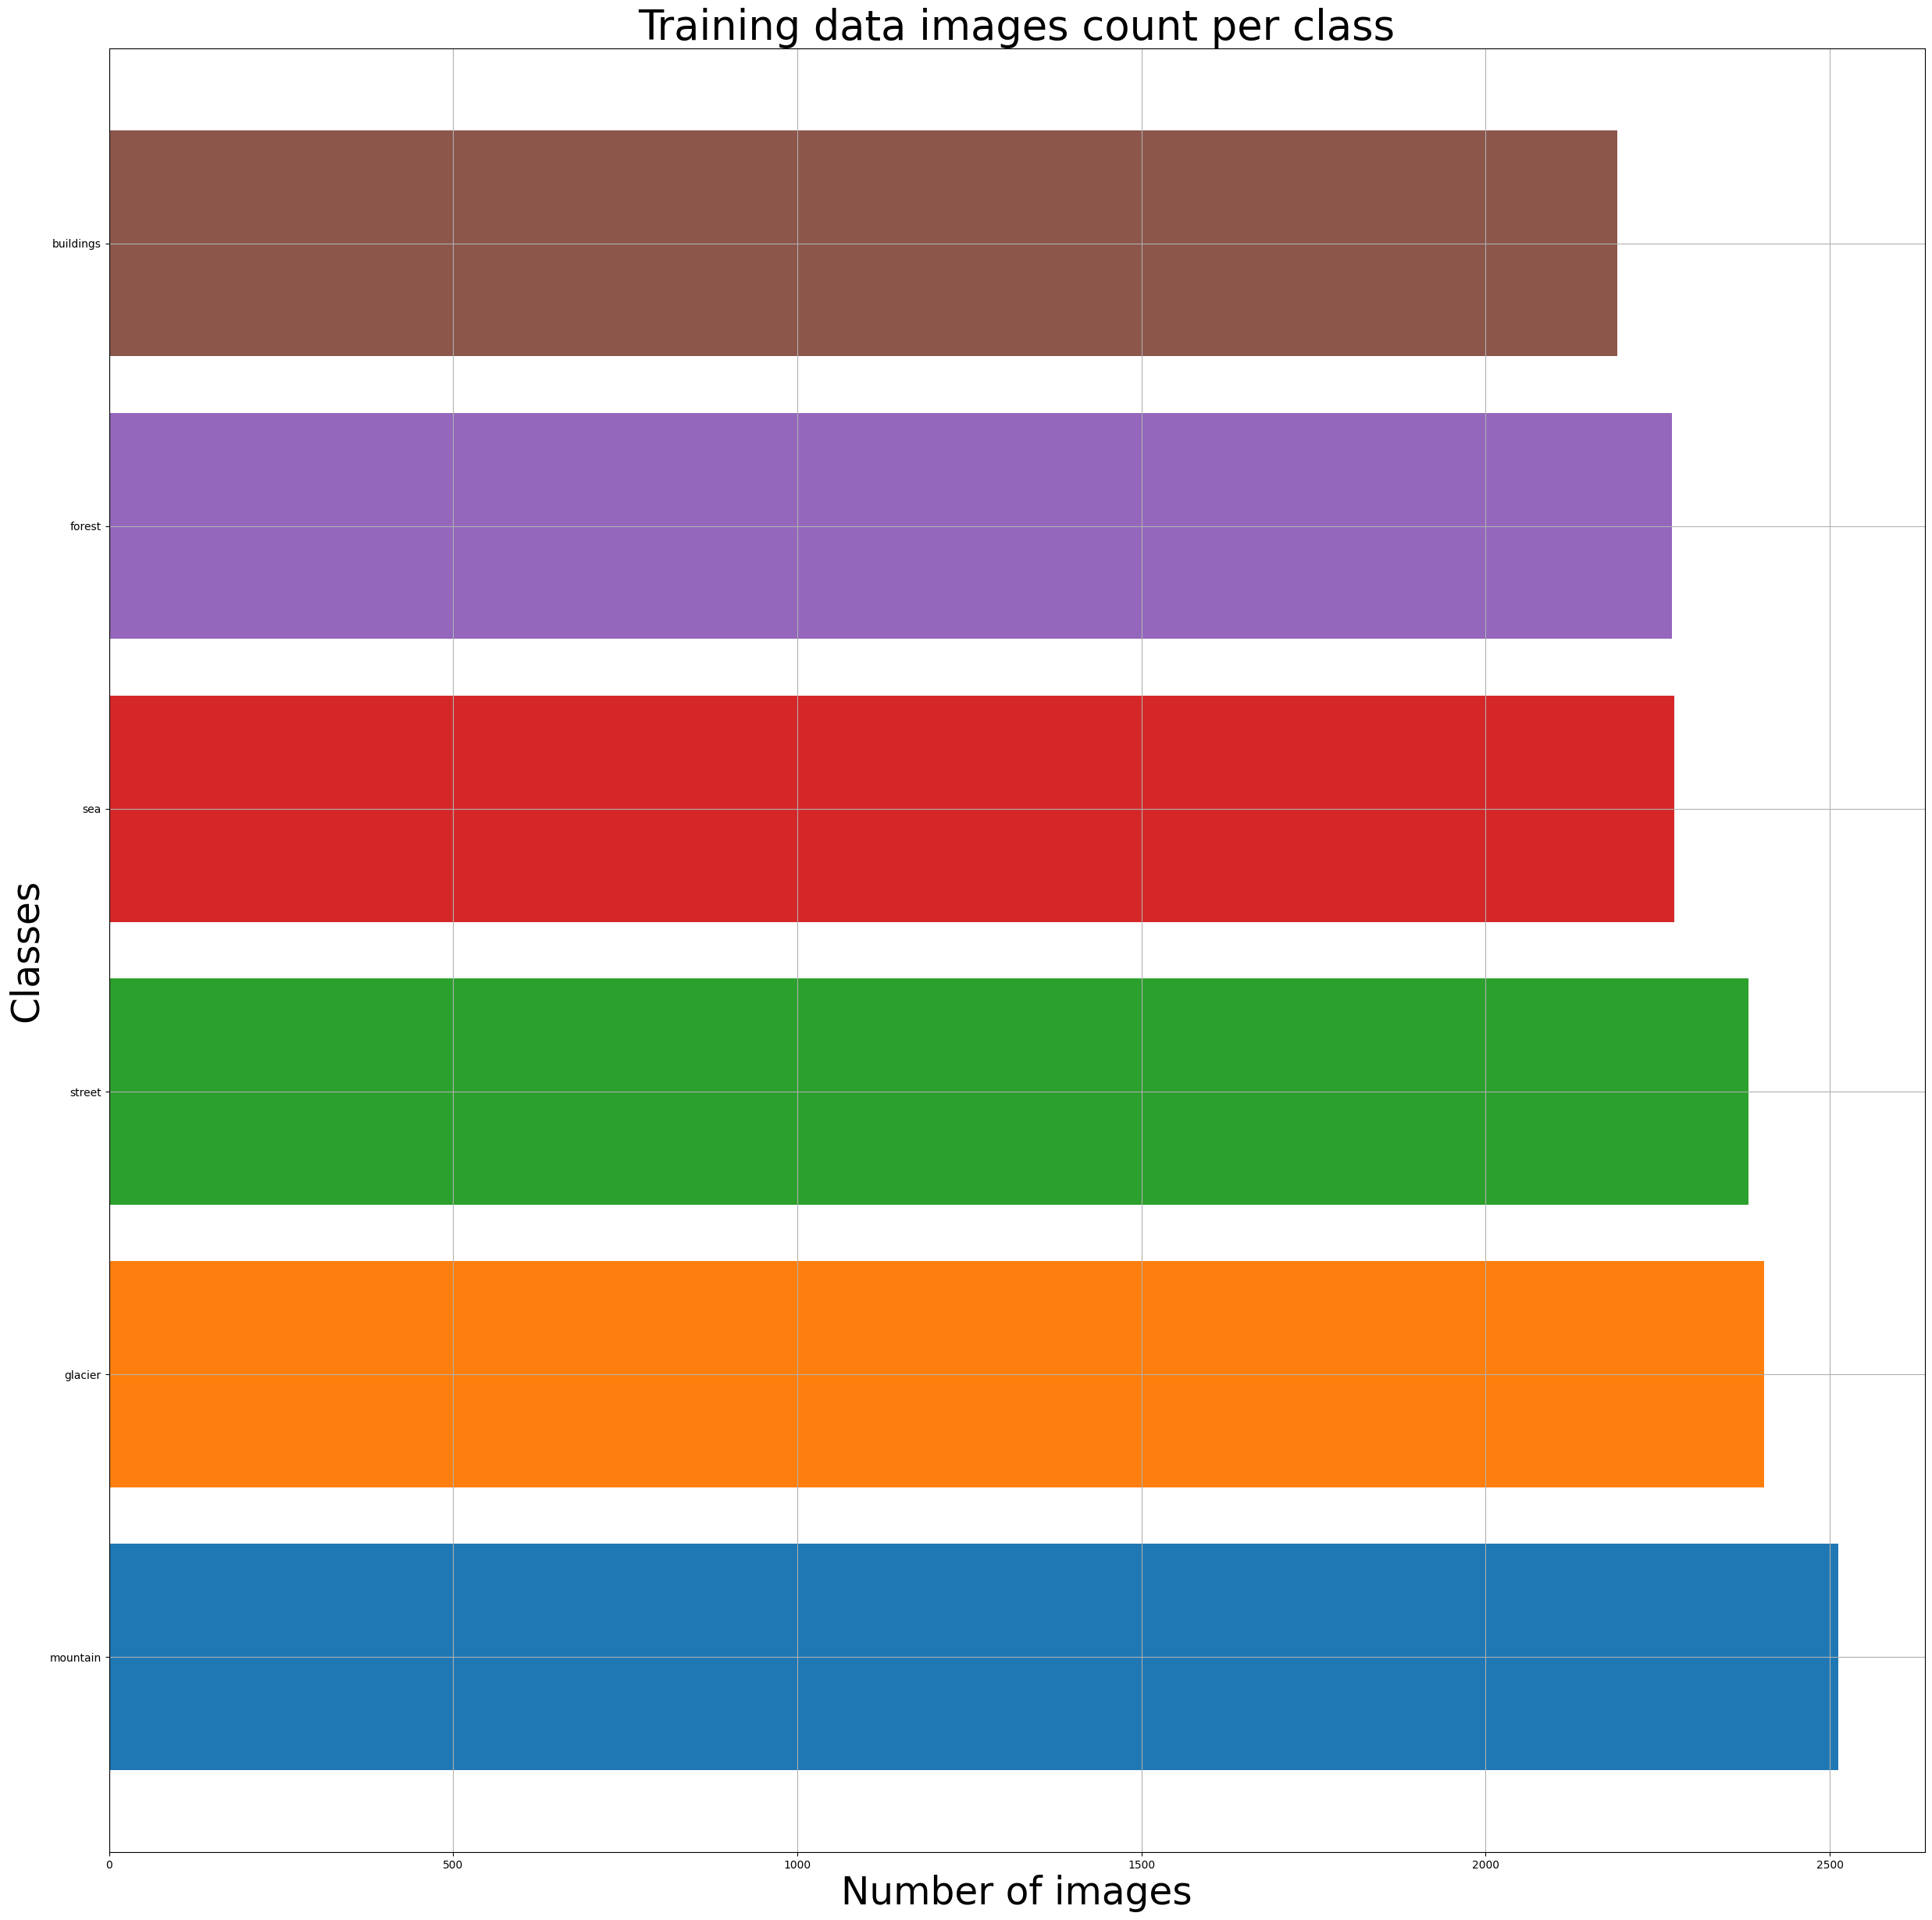

In [17]:
train  = train_df["labels"].value_counts()
label = train.tolist()
index = train.index.tolist()

colors = [
    "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd",
    "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf",
    "#aec7e8", "#ffbb78", "#98df8a", "#ff9896", "#c5b0d5",
    "#c49c94", "#f7b6d2", "#c7c7c7", "#dbdb8d", "#9edae5",
    "#5254a3", "#6b6ecf", "#bdbdbd", "#8ca252", "#bd9e39",
    "#ad494a", "#8c6d31", "#6b6ecf", "#e7ba52", "#ce6dbd",
    "#9c9ede", "#cedb9c", "#de9ed6", "#ad494a", "#d6616b",
    "#f7f7f7", "#7b4173", "#a55194", "#ce6dbd"
]



plt.figure(figsize=(30,30))
plt.title("Training data images count per class",fontsize=38)
plt.xlabel('Number of images', fontsize=35)
plt.ylabel('Classes', fontsize=35)
plt.barh(index,label, color=colors)
plt.grid(True)
plt.show()

In [8]:
train_df.sample(n=15, random_state=1)

imgpath     labels  \
9306   /kaggle/input/intel-image-classification/seg_t...        sea   
5299   /kaggle/input/intel-image-classification/seg_t...  buildings   
5725   /kaggle/input/intel-image-classification/seg_t...  buildings   
8912   /kaggle/input/intel-image-classification/seg_t...        sea   
10406  /kaggle/input/intel-image-classification/seg_t...     forest   
12658  /kaggle/input/intel-image-classification/seg_t...    glacier   
1197   /kaggle/input/intel-image-classification/seg_t...   mountain   
9063   /kaggle/input/intel-image-classification/seg_t...        sea   
11023  /kaggle/input/intel-image-classification/seg_t...     forest   
8333   /kaggle/input/intel-image-classification/seg_t...        sea   
588    /kaggle/input/intel-image-classification/seg_t...   mountain   
5500   /kaggle/input/intel-image-classification/seg_t...  buildings   
5053   /kaggle/input/intel-image-classification/seg_t...  buildings   
6039   /kaggle/input/intel-image-classification/seg_t...  buildings   
2027   /kaggle/input/intel-image-classification/seg_t...   mountain   

       encoded_labels  
9306                4  
5299                0  
5725                0  
8912                4  
10406               1  
12658               2  
1197                3  
9063                4  
11023               1  
8333                4  
588                 3  
5500                0  
5053                0  
6039                0  
2027                3

In [18]:
print("----------Train-------------")
print(train_df[["imagepath", "labels"]].head(5))
print(train_df.shape)
#print("--------Validation----------")
#print(valid_df[["imgpath", "labels"]].head(5))
#print(valid_df.shape)
print("----------Test--------------")
print(test_df[["imagepath", "labels"]].head(5))
print(test_df.shape)

----------Train-------------
                                           imagepath    labels
0  /kaggle/input/intel-image-classification/seg_t...  mountain
1  /kaggle/input/intel-image-classification/seg_t...  mountain
2  /kaggle/input/intel-image-classification/seg_t...  mountain
3  /kaggle/input/intel-image-classification/seg_t...  mountain
4  /kaggle/input/intel-image-classification/seg_t...  mountain
(14034, 3)
----------Test--------------
                                           imagepath    labels
0  /kaggle/input/intel-image-classification/seg_t...  mountain
1  /kaggle/input/intel-image-classification/seg_t...  mountain
2  /kaggle/input/intel-image-classification/seg_t...  mountain
3  /kaggle/input/intel-image-classification/seg_t...  mountain
4  /kaggle/input/intel-image-classification/seg_t...  mountain
(3000, 3)


# **Displaying random images**

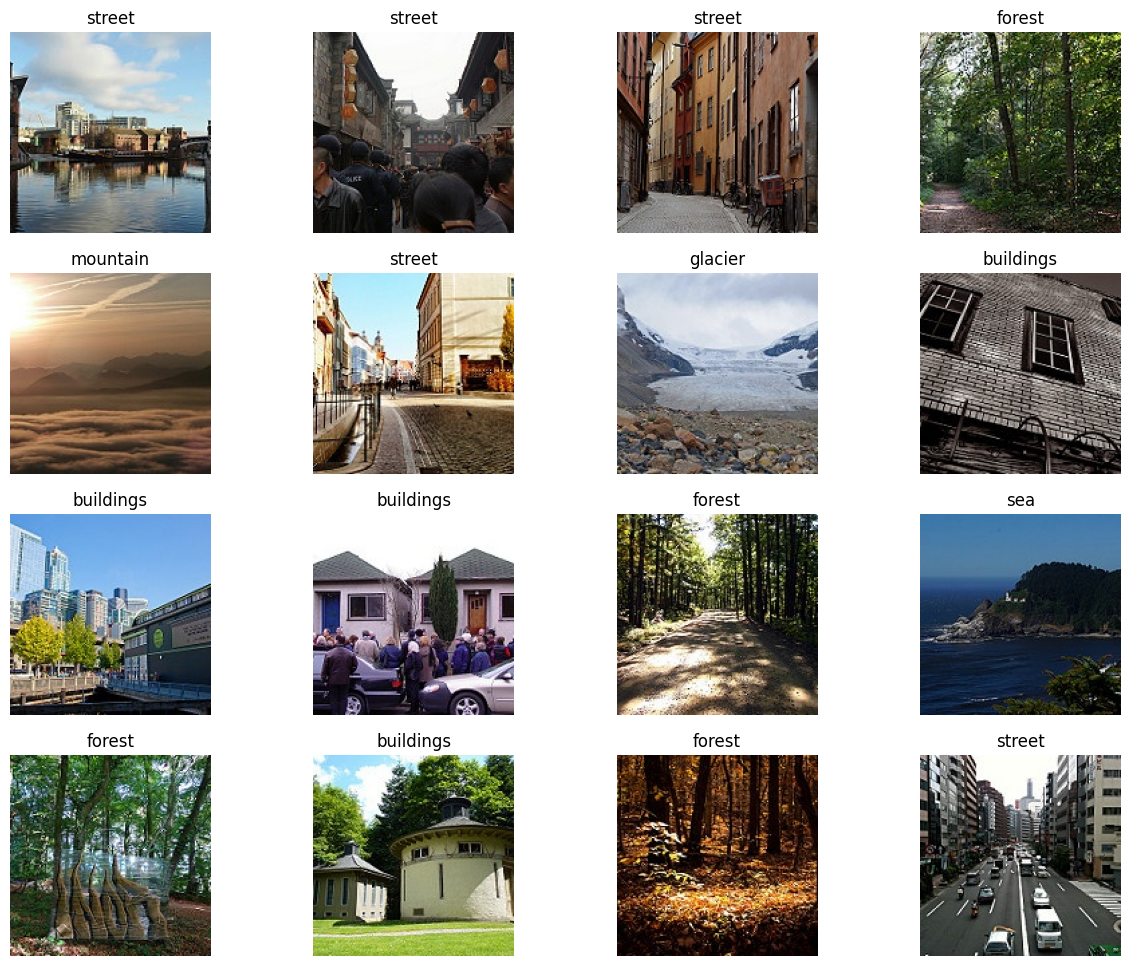

In [19]:
plt.figure(figsize=(15,12))
for i, row in test_df.sample(n=16).reset_index().iterrows():
    plt.subplot(4,4,i+1)
    image_path = row['imagepath']
    image = Image.open(image_path)
    plt.imshow(image)
    plt.title(row["labels"])
    plt.axis('off')
plt.show()

# **Data Augmentation**

In [51]:

train_transforms = transforms.Compose([
    #transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
    transforms.Resize((128, 128)),
    transforms.RandomRotation(degrees=15),
    #transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomHorizontalFlip(),
    transforms.CenterCrop(size=128),
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# **Displaying random sample and the augmented image**

In [21]:
#Load & View Random Sample Image
def load(imagepath, as_tensor=True):
    # Read and decode an image file to a uint8 tensor
    image = Image.open(imagepath).convert('RGB')
    
    if as_tensor:
        converter = transforms.ToTensor()
        return converter(image)
    else:
        return image


def view_sample(image, label, color_map='rgb', fig_size=(8, 10)):
    plt.figure(figsize=fig_size)
    
    if color_map=='rgb':
        plt.imshow(image)
    else:
        plt.imshow(image, cmap=color_map)
    
    plt.title(f'Label: {label}', fontsize=16)
    return

In [22]:
# Select random sample from df
import random
idx = random.sample(df.index.to_list(), 1)[0]

# Load the random sample and label
aug_image = load(df.imagepath[idx], as_tensor=False)

IsADirectoryError: [Errno 21] Is a directory: '/kaggle/input/intel-image-classification/seg_pred/seg_pred'

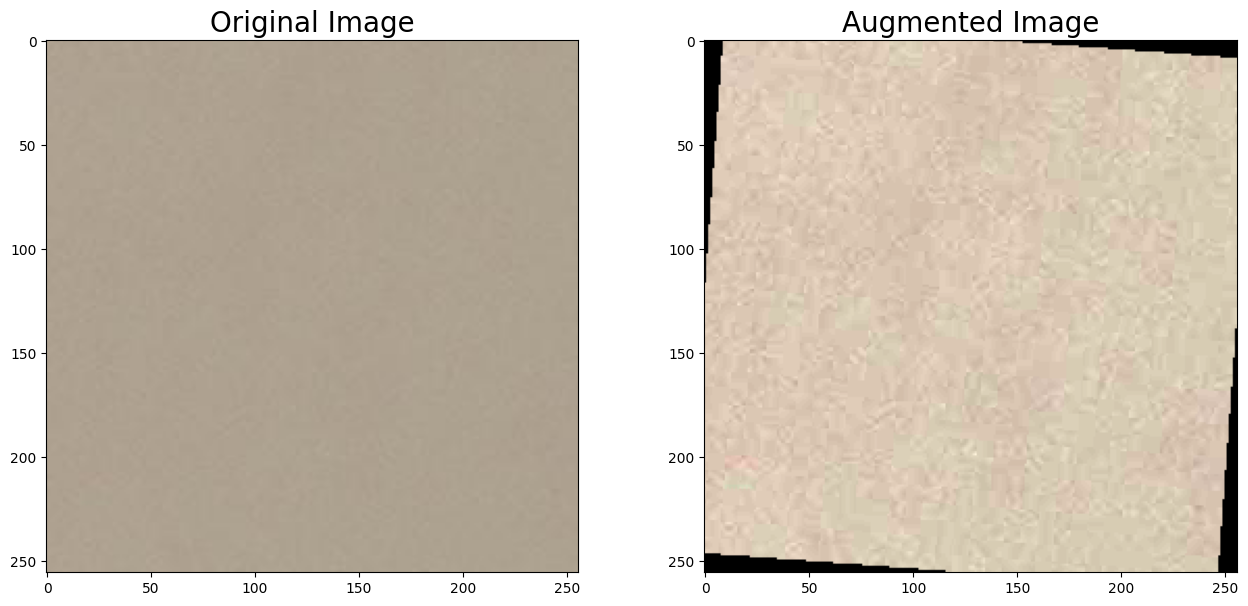

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 10))

# Set the spacing between subplots
fig.tight_layout(pad=6.0)

# View Original Image
ax1.set_title('Original Image', fontsize=20)
ax1.imshow(aug_image);

# View Augmented Image
ax2.set_title('Augmented Image', fontsize=20)
ax2.imshow(train_transforms(aug_image).permute(1, 2, 0));

# **Building datasets based on splits**

In [52]:
from tqdm.notebook import tqdm
from typing import Dict, List, Tuple

In [53]:
class ArSL_Dataset(Dataset):
    def __init__(self, df:pd.DataFrame, transform=None) -> None:
        super().__init__()
        
        self.paths = df['imagepath'].to_list()
        self.labels = df['labels'].to_list()
        self.transform = transform
        
        self.classes = sorted(list(df['labels'].unique()))
        self.class_to_idx = {cls_name: _ for _, cls_name in enumerate(self.classes)}
        
    def load_image(self, index:int) -> Image.Image:
        image_path = self.paths[index]
        return Image.open(image_path).convert('RGB')  
        
    def __len__(self) -> int:
        return self.paths.__len__()
    
    def __getitem__(self, index:int) -> Tuple[torch.Tensor, int]:
        image = self.load_image(index)
        class_name = self.labels[index]
        class_idx = self.class_to_idx[class_name]

        # Transform if necessary
        if self.transform:
            return self.transform(image), class_idx
        else:
            return image, class_idx

In [54]:
# Build train dataset
train_ds = ArSL_Dataset(train_df, transform=train_transforms)

# Build validation dataset
#valid_ds = ArSL_Dataset(valid_df, transform=test_transforms)

# Build test dataset
test_ds = ArSL_Dataset(test_df, transform=test_transforms)

In [55]:
BATCH_SIZE = (
        64 if torch.cuda.device_count() < 2 
        else (64 * torch.cuda.device_count())
    )
train_dataloader = DataLoader(train_ds, batch_size = BATCH_SIZE, shuffle=True)
#valid_dataloader = DataLoader(valid_ds, batch_size = BATCH_SIZE, shuffle= False)
test_dataloader = DataLoader(test_ds, batch_size= BATCH_SIZE , shuffle=False)

print(">> Number of Train Data : {} -- Batch Size : {} -- Number of Batch : {} ".format(len(train_dataloader.dataset) , BATCH_SIZE , len(train_dataloader)))
#print(">> Number of Valid Data : {} -- Batch Size : {} -- Number of Batch : {} ".format(len(valid_dataloader.dataset) , BATCH_SIZE , len(valid_dataloader)))
print(">> Number of  Test Data : {} -- Batch Size : {} -- Number of Batch : {} ".format(len(test_dataloader.dataset) , BATCH_SIZE , len(test_dataloader)))
onebatch = iter(train_dataloader)
train_features, train_labels = next(onebatch)
print("----------Batch Shape--------")
print(f"Feature batch shape: {train_features.size()}")
print("----------Labels Shape--------")
print(f"Labels batch shape: {train_labels.size()}")

>> Number of Train Data : 14034 -- Batch Size : 128 -- Number of Batch : 110 
>> Number of  Test Data : 3000 -- Batch Size : 128 -- Number of Batch : 24 
----------Batch Shape--------
Feature batch shape: torch.Size([128, 3, 128, 128])
----------Labels Shape--------
Labels batch shape: torch.Size([128])


# **ResNext50 Architecture**

In [56]:
from torchvision.models.swin_transformer import swin_s

In [57]:
model = swin_s(pretrained=True)
for param in model.parameters(): #freeze model
    param.requires_grad = False

n_inputs = model.head.in_features
model.head = nn.Sequential(
    nn.Linear(n_inputs, 512),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(512, 6)
)
model = model.to(device)

In [58]:
# Define Loss Function
loss_fn = LabelSmoothingCrossEntropy()

# Define Optimizer
optimizer = optim.Adam(model.parameters(),lr= 0.001)



# **Train Function**

In [59]:
def execute_epoch(
    model:torch.nn.Module,
    dataloader:torch.utils.data.DataLoader,
    optimizer:torch.optim.Optimizer,
    loss_fn:torch.nn.Module,
    device:torch.device) -> Tuple[float, float]:
    
    # Set model into training mode
    model.train()
    
    # Initialize train loss & accuracy
    train_loss, train_acc = 0, 0
    
    # Execute training loop over train dataloader
    for batch, (X, y) in enumerate(tqdm(dataloader)):
        # Load data onto target device
        X, y = X.to(device), y.to(device)
        
        # Feed-forward and compute metrics
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 
        
        # Reset Gradients & Backpropagate Loss
        optimizer.zero_grad()
        loss.backward()
        
        # Update Model Gradients
        optimizer.step()
        
        # Compute Batch Metrics
        predicted_class = torch.argmax(
            torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (predicted_class == y).sum().item() / len(y_pred)
        
    # Compute Step Metrics
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    
    return train_loss, train_acc

# **Evaluation Function**

In [61]:
def evaluate(
    model:torch.nn.Module,
    dataloader:torch.utils.data.DataLoader,
    loss_fn:torch.nn.Module,
    device:torch.device) -> Tuple[float, float]:
    
    # Set model into eval mode
    model.eval()
    
    # Initialize eval loss & accuracy
    eval_loss, eval_acc = 0, 0
    
    # Active inferene context manager
    with torch.inference_mode():
        # Execute eval loop over dataloader
        for batch, (X, y) in enumerate(dataloader):
            # Load data onto target device
            X, y = X.to(device), y.to(device)

            # Feed-forward and compute metrics
            y_pred = model(X)
            loss = loss_fn(y_pred, y)
            eval_loss += loss.item() 

            # Compute Batch Metrics
            predicted_class = torch.argmax(
                torch.softmax(y_pred, dim=1), dim=1)
            eval_acc += (predicted_class == y).sum().item() / len(y_pred)
        
    # Compute Step Metrics
    eval_loss = eval_loss / len(dataloader)
    eval_acc = eval_acc / len(dataloader)
    
    return eval_loss, eval_acc

In [80]:
def train(
    model:torch.nn.Module,
    train_dataloader:torch.utils.data.DataLoader,
    eval_dataloader:torch.utils.data.DataLoader,
    optimizer:torch.optim.Optimizer,
    loss_fn:torch.nn.Module,
    epochs:int,
    device:torch.device) -> Dict[str, List]:
    
    # Initialize training session
    session = {
        'loss'          : [],
        'accuracy'      : [],
        'eval_loss'     : [],
        'eval_accuracy': []
    }
    
    # Training loop
    for epoch in tqdm(range(epochs)):
        # Execute Epoch
        print(f'\nEpoch {epoch + 1}/{epochs}')
        train_loss, train_acc = execute_epoch(
            model, 
            train_dataloader, 
            optimizer, 
            loss_fn, 
            device
        )
        
        # Evaluate Model
        eval_loss, eval_acc = evaluate(
            model, 
            eval_dataloader,
            loss_fn, 
            device
        )
        
        # Log Epoch Metrics
        print(f'loss: {train_loss:.4f} - acc: {train_acc:.4f} - eval_loss: {eval_loss:.4f} - eval_acc: {eval_acc:.4f}')
        
        # Record Epoch Metrics
        session['loss'].append(train_loss)
        session['accuracy'].append(train_acc)
        session['eval_loss'].append(eval_loss)
        session['eval_accuracy'].append(eval_acc)
        
    # Return Session Metrics
    return session

In [81]:
# Train the model 
print(f'Train on {len(train_df)} samples, validate on {len(test_df)} samples.')
print('----------------------------------')

session_config = {
    'model'               : model,
    'train_dataloader'    : train_dataloader,
    'eval_dataloader'     : test_dataloader,
    'optimizer'           : optimizer,
    'loss_fn'             : loss_fn,
    'epochs'              : 10,
    'device'              : device
}

session_history = train(**session_config)

Train on 14034 samples, validate on 3000 samples.
----------------------------------


  0%|          | 0/10 [00:00<?, ?it/s]


Epoch 1/10


  0%|          | 0/110 [00:00<?, ?it/s]

loss: 0.5917 - acc: 0.9278 - eval_loss: 0.5676 - eval_acc: 0.9374

Epoch 2/10


  0%|          | 0/110 [00:00<?, ?it/s]

loss: 0.5877 - acc: 0.9304 - eval_loss: 0.5697 - eval_acc: 0.9353

Epoch 3/10


  0%|          | 0/110 [00:00<?, ?it/s]

loss: 0.5850 - acc: 0.9313 - eval_loss: 0.5831 - eval_acc: 0.9298

Epoch 4/10


  0%|          | 0/110 [00:00<?, ?it/s]

loss: 0.5898 - acc: 0.9287 - eval_loss: 0.5644 - eval_acc: 0.9423

Epoch 5/10


  0%|          | 0/110 [00:00<?, ?it/s]

loss: 0.5847 - acc: 0.9317 - eval_loss: 0.5697 - eval_acc: 0.9372

Epoch 6/10


  0%|          | 0/110 [00:00<?, ?it/s]

loss: 0.5809 - acc: 0.9325 - eval_loss: 0.5721 - eval_acc: 0.9357

Epoch 7/10


  0%|          | 0/110 [00:00<?, ?it/s]

loss: 0.5813 - acc: 0.9323 - eval_loss: 0.5659 - eval_acc: 0.9370

Epoch 8/10


  0%|          | 0/110 [00:00<?, ?it/s]

loss: 0.5766 - acc: 0.9341 - eval_loss: 0.5608 - eval_acc: 0.9411

Epoch 9/10


  0%|          | 0/110 [00:00<?, ?it/s]

loss: 0.5812 - acc: 0.9353 - eval_loss: 0.5877 - eval_acc: 0.9239

Epoch 10/10


  0%|          | 0/110 [00:00<?, ?it/s]

loss: 0.5778 - acc: 0.9375 - eval_loss: 0.5627 - eval_acc: 0.9382


In [ ]:
# lr scheduler
#exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.97)

In [64]:
def predict(
    model:nn.Module, 
    sample_loader:torch.utils.data.DataLoader,
    device:torch.device) -> np.ndarray:
    
    # Set model into eval mode
    model.eval()
    
    predictions = []
    
    # Active inferene context manager
    with torch.inference_mode():
        # Execute eval loop over dataloader
        for batch, (X, y) in enumerate(tqdm(sample_loader)):
            # Load data onto target device
            X, y = X.to(device), y.to(device)

            # Feed-forward and compute metrics
            y_pred = model(X) 

            # Compute Batch Metrics
            predicted_probs = torch.softmax(y_pred, dim=1).cpu().numpy()
            
            # Record prediction
            predictions.append(predicted_probs)
        
    return np.vstack(predictions)

In [65]:
# Generate test sample probabilities 
test_probs = predict(model, test_dataloader, device)

  0%|          | 0/24 [00:00<?, ?it/s]

In [66]:
# Generate test sample preditions 
test_preds = np.argmax(test_probs, axis=1)

In [82]:
def plot_training_curves(history):
    
    loss = np.array(history['loss'])
    val_loss = np.array(history['eval_loss'])

    accuracy = np.array(history['accuracy'])
    val_accuracy = np.array(history['eval_accuracy'])

    epochs = range(len(history['loss']))

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

    # Plot loss
    ax1.plot(epochs, loss, label='training_loss', marker='o')
    ax1.plot(epochs, val_loss, label='eval_loss', marker='o')
    
    ax1.fill_between(epochs, loss, val_loss, where=(loss > val_loss), color='C0', alpha=0.3, interpolate=True)
    ax1.fill_between(epochs, loss, val_loss, where=(loss < val_loss), color='C1', alpha=0.3, interpolate=True)

    ax1.set_title('Loss', fontsize=16)
    ax1.set_xlabel('Epochs', fontsize=12)
    ax1.legend()

    # Plot accuracy
    ax2.plot(epochs, accuracy, label='training_accuracy', marker='o')
    ax2.plot(epochs, val_accuracy, label='validation_accuracy', marker='o')
    
    ax2.fill_between(epochs, accuracy, val_accuracy, where=(accuracy > val_accuracy), color='C0', alpha=0.3, interpolate=True)
    ax2.fill_between(epochs, accuracy, val_accuracy, where=(accuracy < val_accuracy), color='C1', alpha=0.3, interpolate=True)

    ax2.set_title('Accuracy', fontsize=16)
    ax2.set_xlabel('Epochs', fontsize=12)
    ax2.legend();
    
    sns.despine();
    
    return

In [83]:
session_history_df = pd.DataFrame(session_history)
session_history_df

loss  accuracy  eval_loss  eval_accuracy
0  0.591678  0.927837   0.567581       0.937360
1  0.587746  0.930363   0.569745       0.935314
2  0.584978  0.931295   0.583119       0.929827
3  0.589837  0.928738   0.564361       0.942336
4  0.584715  0.931659   0.569729       0.937221
5  0.580881  0.932542   0.572065       0.935686
6  0.581281  0.932338   0.565902       0.937035
7  0.576619  0.934150   0.560802       0.941127
8  0.581155  0.935272   0.587712       0.923921
9  0.577750  0.937514   0.562743       0.938244

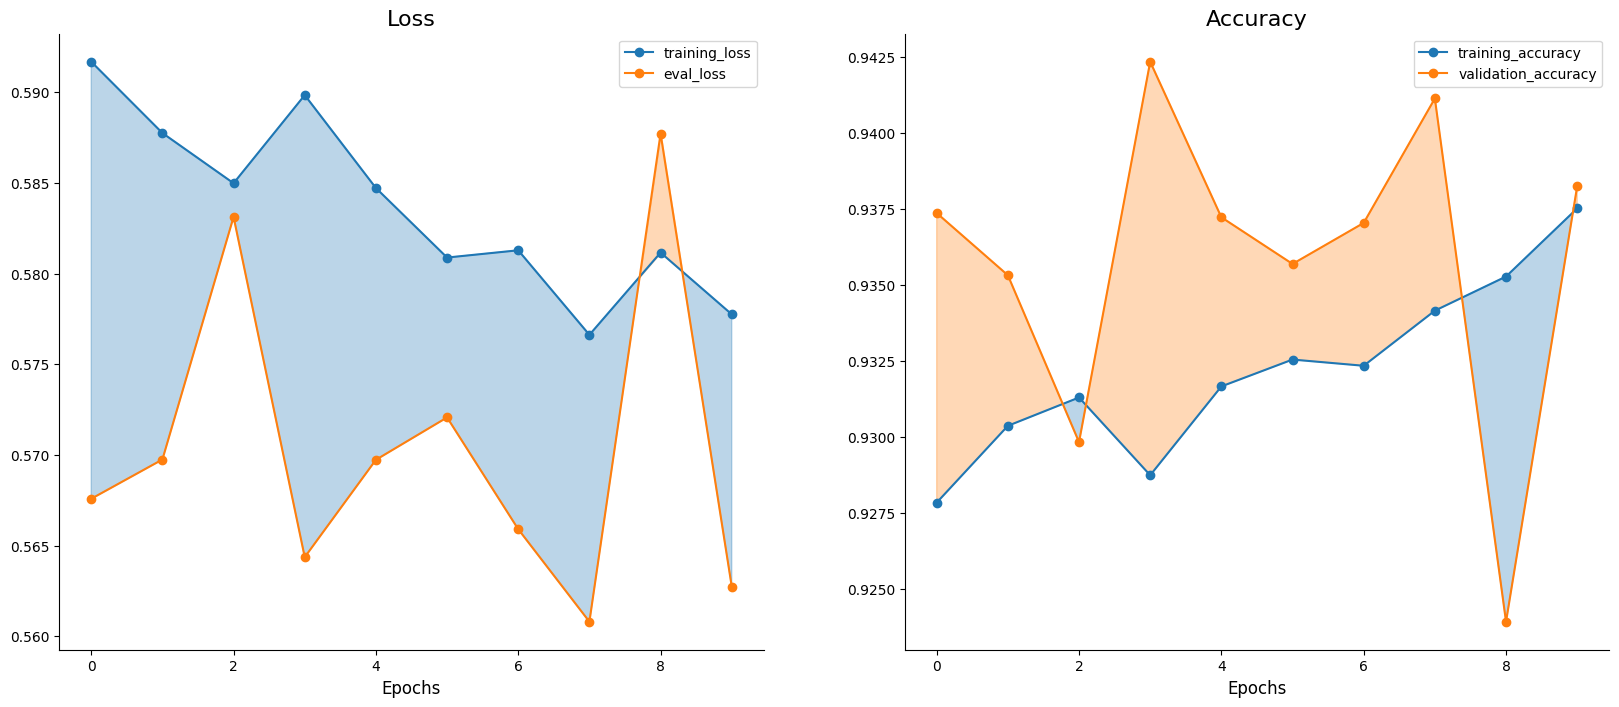

In [84]:
plot_training_curves(session_history)

In [70]:
from sklearn.metrics import (
    classification_report, precision_recall_fscore_support,
    accuracy_score, top_k_accuracy_score, f1_score, 
    matthews_corrcoef, confusion_matrix, ConfusionMatrixDisplay
)

In [ ]:
def plot_confusion_matrix(y_true, y_pred, classes='auto', figsize=(10, 10), text_size=12): 
    # Generate confusion matrix 
    cm = confusion_matrix(y_true, y_pred)
    
    # Set plot size
    plt.figure(figsize=figsize)

    # Create confusion matrix heatmap
    disp = sns.heatmap(
        cm, annot=True, cmap='Greens',
        annot_kws={"size": text_size}, fmt='g',
        linewidths=0.5, linecolor='black', clip_on=False,
        xticklabels=classes, yticklabels=classes)
    
    # Set title and axis labels
    disp.set_title('Confusion Matrix', fontsize=24)
    disp.set_xlabel('Predicted Label', fontsize=20) 
    disp.set_ylabel('True Label', fontsize=20)
    plt.yticks(rotation=0) 

    # Plot confusion matrix
    plt.show()
    
    return

In [ ]:
test_labels = [*map(test_ds.class_to_idx.get, test_ds.labels)]

In [ ]:
#results = model.eval(test_dataloader)

# **Confusion Matrix**

In [ ]:
plot_confusion_matrix(
    test_labels, 
    test_preds, 
    figsize=(22, 16),  
    classes=test_ds.classes)

# **Classification Report**

In [ ]:
print(
    classification_report(
        test_labels, 
        test_preds, 
        target_names=test_ds.classes
    )
)

In [ ]:
 report = classification_report(
        test_labels, 
        test_preds, 
        target_names=test_ds.classes,
        output_dict=True
    )

In [ ]:
df_classification_report = pd.DataFrame(report).transpose()

In [ ]:
df_classification_report.to_csv('classification_report.csv', index=True)

In [ ]:
!pip install git+https://github.com/jacobgil/pytorch-grad-cam.git

In [ ]:
import copy
from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

In [ ]:
target_layers = [model.conv4.pointwise]

In [ ]:
results_df = pd.DataFrame({
    'image_path'       : test_ds.paths,
    'label'            : test_ds.labels,
    'label_encoded'    : test_labels,
    'model_prediction' : test_preds,
    'model_probability': [test_probs[_][pred] for _, pred in zip(range(len(test_probs)), test_preds)]
})

results_df

In [ ]:
pd.set_option('display.max_colwidth', None)
sorted_df = results_df.sort_values(by="model_probability", ascending=False)
sorted_df.head(60)

In [ ]:
sorted_df.to_csv('sorted_df(xception).csv', index=True)

In [ ]:
#pd.set_option('display.max_colwidth', None)
#sorted_df['image_path']

In [ ]:
import torchvision

In [ ]:
paths = "/kaggle/input/arsl-no-background-v2/ARSL-No-BackGround-V2/Zain/Zain_27.jpeg"

rgb_img = Image.open(paths).convert('RGB')
# Max min normalization
rgb_img = (rgb_img - np.min(rgb_img)) / (np.max(rgb_img) - np.min(rgb_img))
# Create an input tensor image for your model
input_tensor = torchvision.transforms.functional.to_tensor(rgb_img).unsqueeze(0).float()
# Note: input_tensor can be a batch tensor with several images!

# Construct the CAM object once, and then re-use it on many images:
cam = GradCAM(model=model, target_layers=target_layers)

grayscale_cam = cam(input_tensor=input_tensor)

# In this example grayscale_cam has only one image in the batch:
grayscale_cam = grayscale_cam[0, :]
visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

**# GRADCAM Visualization**

In [ ]:
Image.fromarray(visualization, 'RGB')

In [ ]:
Image.open(paths).convert('RGB')

**# Miscellaneous**

In [ ]:
def generate_performance_scores(y_true, y_pred, y_probabilities):
    
    model_accuracy = accuracy_score(y_true, y_pred)
    top_3_accuracy = top_k_accuracy_score(
        y_true, y_probabilities, k=3
    )
    model_precision, model_recall, model_f1, _ = (
        precision_recall_fscore_support(
            y_true, y_pred, average="weighted"
        )
    )    
    model_matthews_corrcoef = matthews_corrcoef(y_true, y_pred)
    
    print('=============================================')
    print(f'\nPerformance Metrics:\n')
    print('=============================================')
    print(f'accuracy_score:\t\t{model_accuracy:.4f}\n')
    print('_____________________________________________')
    print(f'top_3_accuracy_score:\t{top_3_accuracy:.4f}\n')
    print('_____________________________________________')
    print(f'precision_score:\t{model_precision:.4f}\n')
    print('_____________________________________________')
    print(f'recall_score:\t\t{model_recall:.4f}\n')
    print('_____________________________________________')
    print(f'f1_score:\t\t{model_f1:.4f}\n')
    print('_____________________________________________')
    print(f'matthews_corrcoef:\t{model_matthews_corrcoef:.4f}\n')
    print('=============================================')
    
    preformance_scores = {
        'accuracy_score'       : model_accuracy,
        'top_3_accuracy'       : top_3_accuracy,
        'precision_score'      : model_precision,
        'recall_score'         : model_recall,
        'f1_score'             : model_f1,
        'matthews_corrcoef'    : model_matthews_corrcoef
    }
    return preformance_scores

In [ ]:
model_performance = generate_performance_scores(
    test_labels,
    test_preds, 
    test_probs
)

In [ ]:
def view_multiple_predictions(df, classes, sample_loader, count=10, color_map='rgb', title=None, fig_size=(14, 10)):
    rows = count//5
    if count%5 > 0:
        rows +=1
    
    idx = random.sample(df.index.to_list(), count)
    
    fig = plt.figure(figsize=fig_size)
    if title != None:
        fig.suptitle(title, fontsize=30)
    
    fig.tight_layout()
    fig.subplots_adjust(top=0.95)
    
    # Setup useful dictionaries
    label_set = {k: v for k, v in enumerate(classes)}
    color_set = {False: 'red', True: 'darkgreen'}
    
    for column, _ in enumerate(idx):
        # Predict label
        img = sample_loader(df.image_path[_]).permute(1, 2, 0)
        
        # Validate prediction correctness
        correct_prediction = (df.model_prediction[_] == df.label_encoded[_])
        
        # Create subplot and assign title
        ax = plt.subplot(rows, 5, column+1)
        ax.set_title(
            f'Actual Label: {df.label[_]}', 
            pad=20, 
            fontsize=14,
            color=color_set[correct_prediction]
        )
        
        # Plot image
        if color_map=='rgb':
            ax.imshow(img)
        else:
            ax.imshow(img, cmap=color_map)
        
        # Plot prediction  & probability
        txt = f'Prediction: {label_set[df.model_prediction[_]]}\nProbability: {(100 * df.model_probability[_]):.2f}%'
        plt.xlabel(txt, fontsize=14, color=color_set[correct_prediction])
        
    return

In [ ]:
view_multiple_predictions(
    results_df,
    test_ds.classes,
    load, 
    count=25, 
    color_map='rgb', 
    title=' ResNext Large Test Predictions',
    fig_size=(24, 30)
)

In [ ]:
# Query incorrect predictions
query_df = results_df[
    results_df['label_encoded'] != results_df['model_prediction']
].reset_index(drop=True)

# View incorrect predictions
query_df

In [ ]:
# Save incorrect predictions info in csv file
query_df.to_csv('incorrect_predictions.csv', index=False)

In [ ]:
view_multiple_predictions(
    query_df,
    test_ds.classes,
    load, 
    count=12, 
    color_map='rgb', 
    title='ResNext Large Incorrect Test Predictions',
    fig_size=(24, 30)
)

In [ ]:
from scikitplot.metrics import plot_roc

In [ ]:
plot_roc(
    test_labels, 
    test_probs, 
    figsize=(16, 14), title_fontsize='large'
);

In [ ]:
torch.save(model.state_dict(), 'saved model(xception)')